### CONDA ENVIRONMENTS

For steps __1. preprocess__ and __2. mip__, `conda activate g5ht-pipeline`

For step __3. segment__, `conda activate segment-torch` or `conda activate torchcu129`

For step __4. spline, 5. orient, 6. warp, 7. reg__

## TODO:

1. quick mp4 for all recordings
2. focus check for all recordings
   1. maybe focus check can be used to specify which z slices are good to use and which frames are good to use
3. for recordings starting in december 2025, need to trim first 2 rather than last 2 z slices
4. flip worms so that VNC is always up
5. fixed mask could be automated, but if not, make sure to save which index is fixed
6. extract behavior
7. posture similarity
   1. posture might consist of the spline + thresholded z-stack
      1. I'm thinking that the orientation shouldn't matter, but the z-planes in focus will, and curvature/spline of the head will
      2. maybe need to actually interpolate to 117 z slices
   2. sub registration problems
   3. label each set of registered frames with one set of ROIs, or auto segment ROIs from each set of registered frames
8. track z over time, which zslices are consistent
   1. focus + correlation
9.  beads -> train/test
10. gfp+1 relative to rfp channel (might only apply to pre december 2025 recordings)
11. wholistic 
    1.  parameter sweep, might change
    2.  python version
12. autocorr/scorr
13. automate z slice trimming
    1.  pre december 2025 (trim last 2 z slices)
    2.  post december 2025 (trim first z slice)
14. photobleaching estimation?
    1.  record immo with serotonin
    2.  at least do it for RFP
15. try deltaF/F [ (F(t) - F0) / F0 ]
16. coding directions (preencounter-baseline) (postencounter-baseline)
17. port everything to engaging

In [2]:
import sys
import os
import importlib
from tqdm import tqdm

try:
    import utils
    is_torch_env = False
except ImportError:
    is_torch_env = True
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

## SPECIFY DATA TO PROCESS

In [3]:
# DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\fluorescent_beads_ch_align\20251219'
DATA_PTH = r'D:\DATA\g5ht-free\20251223'

INPUT_ND2 = 'date-20251223_strain-ISg5HT_condition-starvedpatch_worm005.nd2'

INPUT_ND2_PTH = os.path.join(DATA_PTH, INPUT_ND2)

NOISE_PTH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\noise\noise_042925.tif'

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

STACK_LENGTH = 41

if not is_torch_env:
    noise_stack = utils.get_noise_stack(NOISE_PTH, STACK_LENGTH)
    num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 
    beads_alignment_file = utils.get_beads_alignment_file(INPUT_ND2_PTH)
else:
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

print(INPUT_ND2)
print('Num z-slices: ', STACK_LENGTH)
if not is_torch_env:
    print('Number of frames: ', num_frames)
    print('Height: ', height)
    print('width: ', width)
    print('Number of channels: ', num_channels)
    print('Beads alignment file: ', beads_alignment_file)

date-20251223_strain-ISg5HT_condition-starvedpatch_worm005.nd2
Num z-slices:  41
Number of frames:  1200
Height:  512
width:  512
Number of channels:  2
Beads alignment file:  D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005_chan_alignment.nd2


## 0. PROCESS BEADS ALIGNMENT DATA (OPTIONAL, CHANGING THIS SO BEADS ARE PROCESSED SEAMLESSLY IN PIPELINE)

` conda activate g5ht-pipeline`

The registration parameters between green and red channels will be applied to worm recordings

### SHEAR CORRECT AND CHANNEL REGISTER

In [ ]:
from preprocess_parallel import main as preprocess_nd2_parallel
_ = importlib.reload(sys.modules['preprocess_parallel'])

num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 

# # command-line arguments
sys.argv = ["", beads_alignment_file, "0", str(num_frames_beads-1), NOISE_PTH, STACK_LENGTH, 5, num_frames_beads, height, width, num_channels]

# # Call the main function
preprocess_nd2_parallel()

### MIP

This step saved the median channel registration parameters, need to do this somewhere else

In [ ]:
from mip import main as mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
sys.argv = ["", beads_alignment_file, STACK_LENGTH, num_frames_beads, 2]

# Call the main function
mip()

## 1. SHEAR CORRECTION

` conda activate g5ht-pipeline`

- shear corrects each volume
  - depending on each exposure time, it can take roughly half a second between the first and last frames of a volume, so any movements need to be corrected for
- creates one `.tif` for each volume and stores it in the `shear_corrected` directory

##### TODO: should probably update stack length after shear correction since we cut it by 2, although not sure it's explicitly needed

In [ ]:
import shear_correct
_ = importlib.reload(sys.modules['shear_correct'])

# start_index = "0"
# end_index = str(num_frames-1)
start_index = "800"
end_index = "803"
cpu_count = str(int(os.cpu_count() / 2))

# sys.argv = ["", nd2 file, start_frame, end_frame, noise_pth, stack_length, n_workers, num_frames, height, width, num_channels]
sys.argv = ["", INPUT_ND2_PTH, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels]

# Call the main function
shear_correct.main()

## 2. CHANNEL ALIGNMENT

` conda activate g5ht-pipeline`

### 2a. GET MEDIAN CHANNEL ALIGNMENT PARAMETERS FROM ALL FRAMES

- If channel alignment file found, uses that, if not uses worm recording
- creates a `.txt` file for each volume that contains elastix channel registration parameters
- creates `chan_align_params.csv` and  `chan_align.txt`

In [ ]:
beads_alignment_file

In [ ]:
import get_channel_alignment
import median_channel_alignment
_ = importlib.reload(sys.modules['get_channel_alignment'])
_ = importlib.reload(sys.modules['median_channel_alignment'])

## set beads_alignment_file to None to use worm recording for channel alignment, even if beads file exists
# beads_alignment_file = None

start_index = "0"
cpu_count = str(int(os.cpu_count() / 2))

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", beads_alignment_file, start_index, str(num_frames_beads-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames_beads, height, width, num_channels, align_with_beads]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]

# # Call the main function
get_channel_alignment.main()
median_channel_alignment.main()


### 2b. APPLY MEDIAN CHANNEL ALIGNMENT PARAMETERS

- ouputs aligned volumes in `channel_aligned` directory

In [ ]:
import apply_channel_alignment
_ = importlib.reload(sys.modules['apply_channel_alignment'])

start_index = "0800"
cpu_count = str(int(os.cpu_count() / 2))

# 0786 to 0799 are bad frames in worm005.nd2, copied 0785 for each of those frames

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads, beads_alignment_file]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, str(num_frames-1), NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]


# Call the main function
apply_channel_alignment.main()

In [ ]:
# # create copies of 0785 and rename it to 0786 to 0799
# import shutil
# for i in range(786, 800):
#     shutil.copyfile(r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned\0785.tif',
#                     r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned\{:04d}.tif'.format(i))

### 2c. PLOT CHANNEL ALIGNMENT PARAMETER DISTRIBUTIONS

In [ ]:
out_dir

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# make font sizes larger for visibility
plt.rcParams.update({'font.size': 18})

out_dir = os.path.splitext(INPUT_ND2_PTH)[0]

df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

# the xaxis limits for each subplot should be the same across figures

xlims = np.zeros((6,2))

plt.figure(figsize=(12,8), tight_layout=True)
for i,param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.hist(df[param], bins=30, color='red', alpha=0.6)
    # plot the median value as a vertical line
    median_value = df[param].median()
    plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')
    # get xaxis limits
    xlims[i,:] = plt.xlim()
    # title is median value
    plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
plt.show()

out_dir = os.path.splitext(INPUT_ND2_PTH)[0] + '_chan_alignment'
df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

plt.figure(figsize=(12,8), tight_layout=True)
for i,param in enumerate(params):
    plt.subplot(2, 3, i+1)
    plt.hist(df[param], bins=30, color='blue', alpha=0.6)
    # plot the median value as a vertical line
    median_value = df[param].median()
    plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
    plt.xlabel(labels[i])
    plt.ylabel('Frequency')
    # apply xlims
    # plt.xlim(xlims[i,0], xlims[i,1])
    # title is median value, font size 14
    plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
plt.show()

In [ ]:
df.head()

## 3. BLEACH CORRECTION

TODO:
- per z slice?



In [4]:
import importlib
import os
import sys

import bleach_correct
_ = importlib.reload(sys.modules['bleach_correct'])


PTH = os.path.splitext(INPUT_ND2_PTH)[0]
REG_DIR = 'channel_aligned' # 'channel_aligned' or 'tif' 
channels = 1
method = 'block' # 'block' or 'exponential'
mode = 'total' # 'total' or 'median'

bleach_correct.correct_bleaching(os.path.join(PTH,REG_DIR), channels=channels, method=method, fbc=0.04, intensity_mode=mode)


# # Correct RFP only with block method (default)
# correct_bleaching("path/to/data")

# # Correct both channels with exponential fit
# correct_bleaching("path/to/data", channels=[0, 1], method='exponential')

# # Command line
# python bleach_correct.py path/to/data --channels 0 1 --method exponential

Found 1200 volumes in D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005\channel_aligned
Channels to correct: ['RFP']
Method: block
Intensity mode: total

Processing RFP channel (index 1)
  Calculating total RFP signal...
Calculating RFP total signal: volume 1200/1200
  Divided into 25 blocks
  Computing block mean signals...
    Block 1/25: volumes 0-67, mean signal = 3.17e+08
    Block 2/25: volumes 68-84, mean signal = 3.13e+08
    Block 3/25: volumes 85-109, mean signal = 3.10e+08
    Block 4/25: volumes 110-127, mean signal = 3.05e+08
    Block 5/25: volumes 128-139, mean signal = 3.01e+08
    Block 6/25: volumes 140-145, mean signal = 2.97e+08
    Block 7/25: volumes 146-163, mean signal = 2.93e+08
    Block 8/25: volumes 164-180, mean signal = 2.90e+08
    Block 9/25: volumes 181-211, mean signal = 2.86e+08
    Block 10/25: volumes 212-278, mean signal = 2.81e+08
    Block 11/25: volumes 279-310, mean signal = 2.78e+08
    Block 12/25: volumes 

## 4 MIP & DRIFT ESTIMATION

` conda activate g5ht-pipeline`

- outputs `means.png`, `focus.png`, `mip.tif`, and `mip.mp4`, `focus_check.csv`, `z_selection.csv`, `z_selection_diagnostics.png`, `sharpness.csv`

##### TODO: 
- legend for focus.png, should be frame#
- mip for xy, xz, zy
- mip for several slices

In [144]:
import mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
framerate = 10
tif_dir = 'bleach_corrected_RFP_block' # one of 'shear_corrected' 'channel_aligned' 'bleach_corrected_RFP_block'
# tif_dir = 'channel_aligned_beads'
rmax = 750
gmax = 100
mp4_quality = 5
sys.argv = ["", INPUT_ND2_PTH, tif_dir, STACK_LENGTH, num_frames, framerate, rmax, gmax, mp4_quality]

# Call the main function
mip.main()

Computing sharpness-based focus metrics...


Computing sharpness: 100%|██████████| 1200/1200 [05:45<00:00,  3.47it/s]



Z-slice selection complete:
  Total frames: 1200
  Z-slices per frame: 24
  Frames needing padding: 1084 (90.3%)
  Total drift: 11.09 z-slices
  Max drift from start: 18.20 z-slices


#### DRIFT ESTIMATION

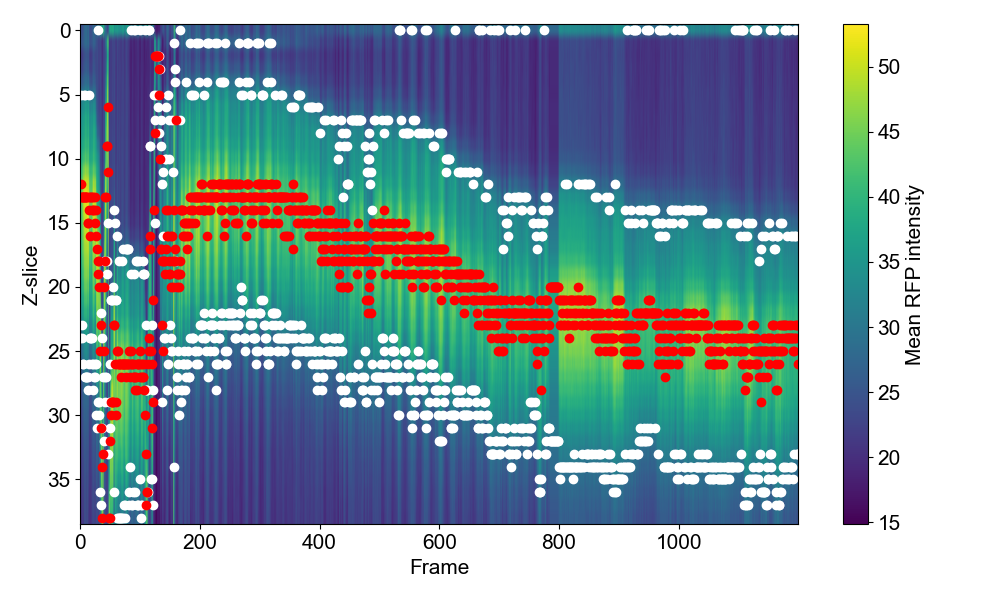

In [ ]:
%matplotlib widget

# plot focus as a heatmap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import default_plt_params
default_plt_params()

# load focus_check.csv
# columns are z slice
# rows are frames
out_dir = os.path.splitext(INPUT_ND2_PTH)[0]
focus = pd.read_csv(os.path.join(out_dir, 'focus_check.csv')).to_numpy()
plt.figure(figsize=(10,6), tight_layout=True)
plt.imshow(focus.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean RFP intensity')

# plot a point where focus is closest to a value (30 for now)
best_focus_value = 30
best_focus_indices = np.argmin(np.abs(focus - best_focus_value), axis=1)
plt.plot(np.arange(focus.shape[0]), best_focus_indices, marker='o', color='white', linewidth=0)

# plot a red point at maximum value for each frame
max_focus_indices = np.argmax(focus, axis=1)
plt.plot(np.arange(focus.shape[0]), max_focus_indices, marker='o', color='red', linewidth=0)

plt.xlabel('Frame')
plt.ylabel('Z-slice')
plt.tight_layout()
plt.show()

In [29]:
# use focus to extract z-slices with best focus
# best focus is defined by a minimum mean RFP intensity value up to the maximum mean RFP intensity
# there should be two such slices per frame
min_intensity = 30

# extract for each frame, the z slice at which the mean RFP intensity is maximum and above min_intensity
best_slices = []
for frame in range(focus.shape[0]):
    frame_focus = focus[frame, :]
    max_intensity = np.max(frame_focus)
    # get all z-slices where intensity is above min_intensity and below max_intensity
    valid_slices = np.where((frame_focus >= min_intensity) & (frame_focus <= max_intensity))[0]
    best_slices.append(valid_slices.tolist())




In [30]:
max_intensity

np.float64(40.83697509765625)

In [33]:
n = [len(slices) for slices in best_slices]

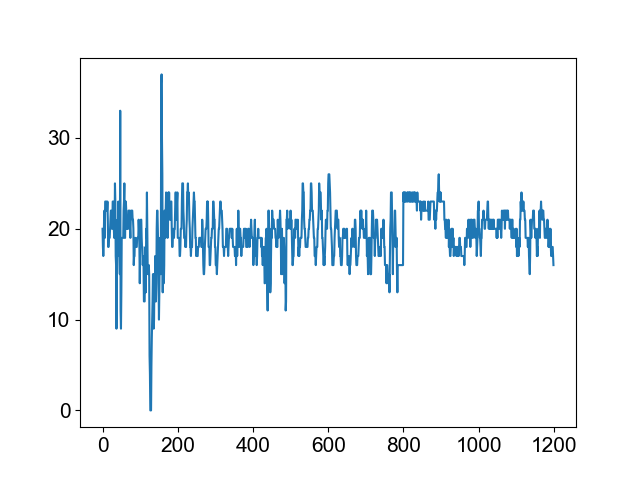

In [35]:
plt.figure()
plt.plot(n)
plt.show()

In [131]:
import numpy as np
from scipy.ndimage import uniform_filter1d

def causal_ewma(x, alpha=0.1):
    """
    Causal exponential weighted moving average.
    alpha: smoothing factor in (0,1]. Smaller = smoother.
    """
    y = np.zeros_like(x, dtype=float)
    y[0] = x[0]
    for t in range(1, len(x)):
        y[t] = alpha * x[t] + (1 - alpha) * y[t-1]
    return y


def causal_median_filter(x, window=5):
    """
    Causal median filter: at time t, median of x[max(0,t-window+1):t+1].
    """
    y = np.zeros_like(x, dtype=float)
    for t in range(len(x)):
        start = max(0, t - window + 1)
        y[t] = np.median(x[start:t+1])
    return y


def parabolic_subslice_peak(y, k):
    """
    Sub-slice peak refinement using a parabola through (k-1, k, k+1).
    Returns a fractional offset delta in [-1, 1] added to k.
    """
    if k <= 0 or k >= len(y) - 1:
        return 0.0
    y0, y1, y2 = y[k-1], y[k], y[k+1]
    denom = (y0 - 2.0 * y1 + y2)
    if denom == 0:
        return 0.0
    delta = 0.5 * (y0 - y2) / denom
    return float(np.clip(delta, -1.0, 1.0))


def compute_focus_confidence(focus, mode="sharpness"):
    """
    Compute confidence score for each frame.
    
    Modes:
    - "ratio": peak / second_peak ratio
    - "sharpness": normalized variance of the focus profile (sharper peak = higher confidence)
    - "snr": peak signal-to-noise ratio
    """
    T, Z = focus.shape
    conf = np.zeros(T)
    
    if mode == "ratio":
        sorted_vals = np.sort(focus, axis=1)
        peak = sorted_vals[:, -1]
        second = sorted_vals[:, -2] if Z >= 2 else np.zeros(T)
        conf = np.where(second > 0, peak / (second + 1e-12), 1.0)
        
    elif mode == "sharpness":
        # Sharpness: how peaked is the focus profile?
        # Higher variance around the peak = sharper focus = higher confidence
        for t in range(T):
            profile = focus[t, :]
            # Normalize profile
            profile_norm = (profile - profile.min()) / (profile.max() - profile.min() + 1e-12)
            # Measure how concentrated the intensity is (entropy-like)
            conf[t] = np.var(profile_norm) * 10  # scale for interpretability
            
    elif mode == "snr":
        # Signal-to-noise: peak relative to background noise
        for t in range(T):
            profile = focus[t, :]
            peak_val = profile.max()
            # Use lower quartile as noise estimate
            noise = np.percentile(profile, 25)
            conf[t] = (peak_val - noise) / (noise + 1e-12)
    
    return conf


def track_focus_plane_improved(
    focus,
    refine_subslice=True,
    smooth_method="ewma",  # "ewma", "median", or None
    smooth_param=0.2,  # alpha for ewma, window for median
    confidence_mode="sharpness",
    min_confidence=0.5,
    outlier_threshold=3.0,  # z-slices away from running estimate
):
    """
    Improved focus plane tracking with causal smoothing and outlier rejection.
    
    Parameters:
    -----------
    focus : ndarray, shape (T, Z)
        Focus metric per frame per z-slice (higher = more in-focus).
    refine_subslice : bool
        If True, use parabolic interpolation for sub-slice precision.
    smooth_method : str or None
        "ewma" for exponential weighted moving average (causal)
        "median" for causal median filter
        None for no smoothing
    smooth_param : float
        For "ewma": alpha (0.1-0.3 recommended), smaller = smoother
        For "median": window size (odd integer recommended)
    confidence_mode : str
        Method to compute confidence: "ratio", "sharpness", or "snr"
    min_confidence : float
        Minimum confidence to trust a measurement
    outlier_threshold : float
        Reject measurements more than this many z-slices from running estimate
    
    Returns:
    --------
    z_tracked : ndarray (T,)
        Tracked focus z position (float if refined)
    z_raw : ndarray (T,)
        Raw (unsmoothed) z estimates
    confidence : ndarray (T,)
        Confidence score per frame
    drift : ndarray (T,)
        Drift relative to first frame (in z-slices)
    quality_mask : ndarray (T,) bool
        True for frames with good tracking quality
    """
    focus = np.asarray(focus, dtype=float)
    T, Z = focus.shape
    
    # 1) Integer peak per frame
    z_int = np.argmax(focus, axis=1).astype(float)
    
    # 2) Sub-slice refinement
    if refine_subslice:
        z_raw = np.empty(T, dtype=float)
        for t in range(T):
            k = int(z_int[t])
            delta = parabolic_subslice_peak(focus[t], k)
            z_raw[t] = k + delta
    else:
        z_raw = z_int.copy()
    
    # 3) Compute confidence
    confidence = compute_focus_confidence(focus, mode=confidence_mode)
    
    # 4) Outlier detection and rejection (causal)
    z_cleaned = z_raw.copy()
    quality_mask = np.ones(T, dtype=bool)
    running_estimate = z_raw[0]
    
    for t in range(T):
        deviation = abs(z_raw[t] - running_estimate)
        
        if confidence[t] < min_confidence or deviation > outlier_threshold:
            # Low confidence or outlier: hold previous estimate
            z_cleaned[t] = running_estimate
            quality_mask[t] = False
        else:
            # Good measurement: update running estimate (simple causal update)
            running_estimate = 0.7 * running_estimate + 0.3 * z_raw[t]
            z_cleaned[t] = z_raw[t]
    
    # 5) Causal smoothing
    if smooth_method == "ewma":
        z_tracked = causal_ewma(z_cleaned, alpha=smooth_param)
    elif smooth_method == "median":
        z_tracked = causal_median_filter(z_cleaned, window=int(smooth_param))
    else:
        z_tracked = z_cleaned.copy()
    
    # 6) Drift relative to first frame
    drift = z_tracked - z_tracked[0]
    
    return z_tracked, z_raw, confidence, drift, quality_mask


def select_reliable_z_slices(
    focus,
    z_tracked,
    quality_mask,
    margin=2,
    min_presence_fraction=0.8,
    intensity_threshold_percentile=20,
):
    """
    Select z-slices that are reliably in the focal range throughout the recording.
    
    Parameters:
    -----------
    focus : ndarray (T, Z)
        Focus metric array
    z_tracked : ndarray (T,)
        Tracked focus position over time
    quality_mask : ndarray (T,) bool
        True for frames with reliable tracking
    margin : int
        Number of z-slices above/below the tracked focus to include
    min_presence_fraction : float
        Minimum fraction of frames a z-slice must be in range to be "reliable"
    intensity_threshold_percentile : float
        Minimum intensity percentile to consider a z-slice in focus
        
    Returns:
    --------
    reliable_slices : list of int
        Z-slice indices that are reliably tracked
    slice_presence : ndarray (Z,)
        Fraction of frames each z-slice is in focal range
    focal_range_per_frame : list of arrays
        Which z-slices are in focus for each frame
    """
    T, Z = focus.shape
    
    # For each frame, determine which z-slices are "in focus"
    focal_range_per_frame = []
    slice_counts = np.zeros(Z)
    
    # Compute intensity threshold per frame
    for t in range(T):
        if not quality_mask[t]:
            focal_range_per_frame.append(np.array([]))
            continue
            
        z_center = z_tracked[t]
        z_lo = max(0, int(np.floor(z_center - margin)))
        z_hi = min(Z - 1, int(np.ceil(z_center + margin)))
        
        # Also filter by intensity: only include slices with sufficient signal
        profile = focus[t, :]
        intensity_thresh = np.percentile(profile, intensity_threshold_percentile)
        
        in_focus = []
        for z in range(z_lo, z_hi + 1):
            if profile[z] >= intensity_thresh:
                in_focus.append(z)
                slice_counts[z] += 1
        
        focal_range_per_frame.append(np.array(in_focus))
    
    # Calculate presence fraction
    n_good_frames = quality_mask.sum()
    slice_presence = slice_counts / max(n_good_frames, 1)
    
    # Select reliable slices
    reliable_slices = np.where(slice_presence >= min_presence_fraction)[0].tolist()
    
    return reliable_slices, slice_presence, focal_range_per_frame


def summarize_focus_tracking(focus, z_tracked, drift, quality_mask, reliable_slices, dz_um=1.0):
    """
    Print a summary of the focus tracking results.
    """
    T, Z = focus.shape
    
    print("=" * 60)
    print("FOCUS TRACKING SUMMARY")
    print("=" * 60)
    print(f"Total frames: {T}")
    print(f"Z-slices: {Z}")
    print(f"Good quality frames: {quality_mask.sum()} ({100*quality_mask.mean():.1f}%)")
    print()
    print(f"Focus plane range: {z_tracked.min():.2f} - {z_tracked.max():.2f} z-slices")
    print(f"Total drift: {drift[-1]:.2f} z-slices ({drift[-1]*dz_um:.2f} µm)")
    print(f"Max drift from start: {np.abs(drift).max():.2f} z-slices ({np.abs(drift).max()*dz_um:.2f} µm)")
    print()
    print(f"Reliable z-slices ({len(reliable_slices)} total): {reliable_slices}")
    print("=" * 60)

In [ ]:
out_dir = os.path.splitext(INPUT_ND2_PTH)[0]
dat = pd.read_csv(os.path.join(out_dir, 'focus_check.csv')).to_numpy()

# Run the improved focus tracking
z_tracked, z_raw, confidence, drift, quality_mask = track_focus_plane_improved(
    dat,
    refine_subslice=True,
    smooth_method="ewma",      # Causal exponential moving average
    smooth_param=0.15,         # Alpha: smaller = smoother (0.1-0.3 recommended)
    confidence_mode="sharpness",
    min_confidence=0.1,
    outlier_threshold=3.0,     # Reject jumps > 3 z-slices from running estimate
)

# Select reliably tracked z-slices
reliable_slices, slice_presence, focal_range_per_frame = select_reliable_z_slices(
    dat,
    z_tracked,
    quality_mask,
    margin=2,                      # Include z-slices within ±2 of focus
    min_presence_fraction=0.1,     # Must be present in 70% of good frames
    intensity_threshold_percentile=15,
)

# Print summary
dz_um = 1.08  # Z step in microns
summarize_focus_tracking(dat, z_tracked, drift, quality_mask, reliable_slices, dz_um=dz_um)

# Convert drift to microns
drift_um = drift * dz_um

FOCUS TRACKING SUMMARY
Total frames: 1200
Z-slices: 39
Good quality frames: 944 (78.7%)

Focus plane range: 12.45 - 25.09 z-slices
Total drift: 10.40 z-slices (11.24 µm)
Max drift from start: 11.83 z-slices (12.78 µm)

Reliable z-slices (16 total): [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


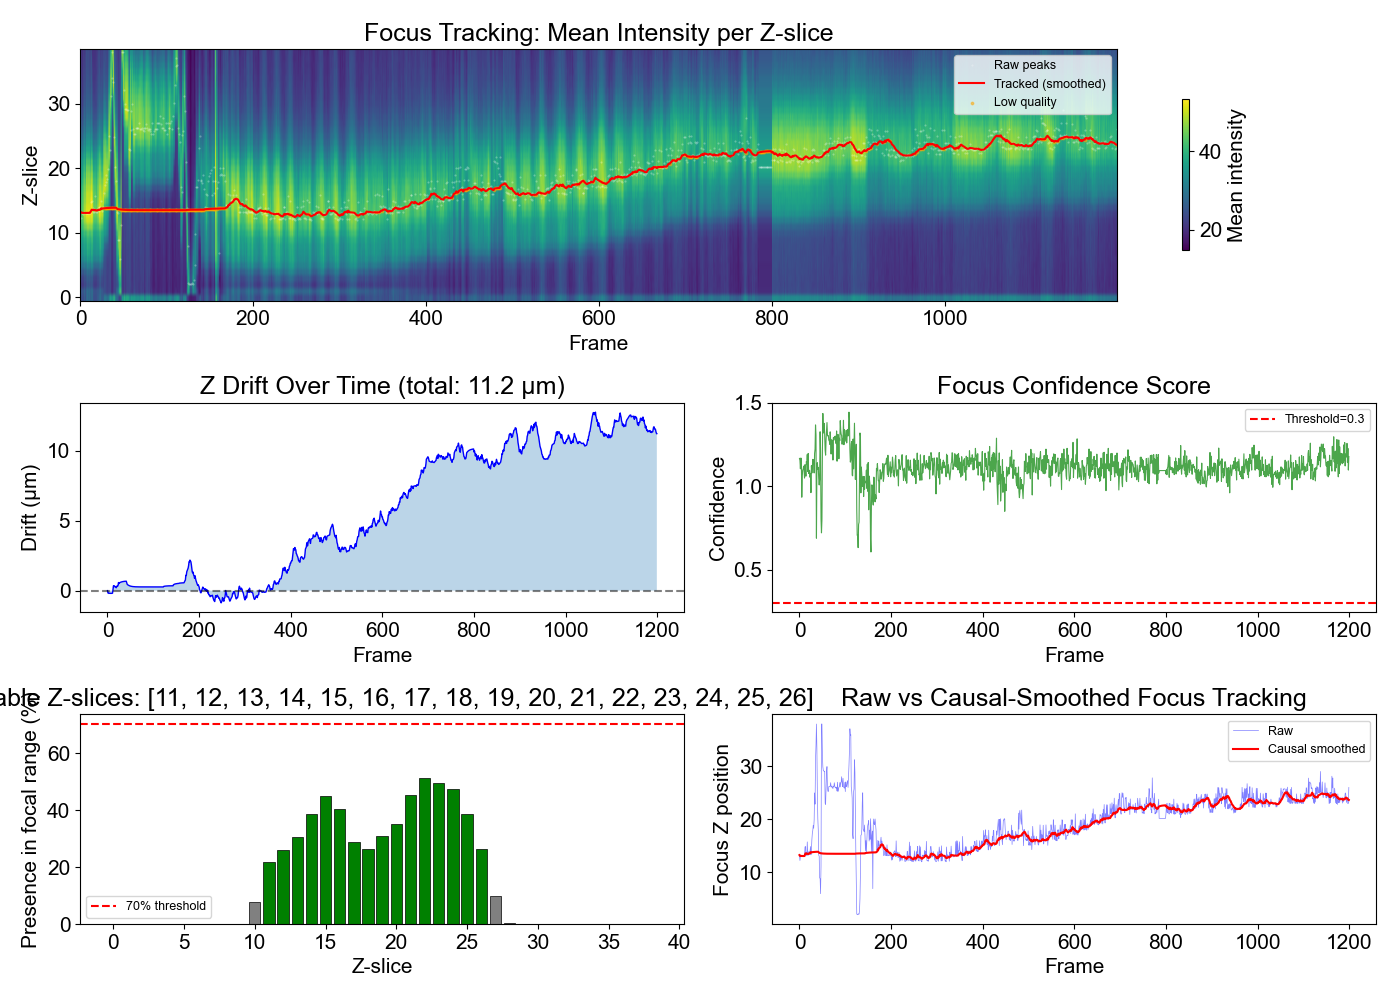

In [139]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 10), tight_layout=True)
gs = GridSpec(3, 2, figure=fig, height_ratios=[1.2, 1, 1])

# 1) Focus heatmap with tracked focus overlaid
ax1 = fig.add_subplot(gs[0, :])
im = ax1.imshow(dat.T, aspect='auto', cmap='viridis', origin='lower')
ax1.plot(np.arange(len(z_raw)), z_raw, 'w.', markersize=1, alpha=0.3, label='Raw peaks')
ax1.plot(np.arange(len(z_tracked)), z_tracked, 'r-', linewidth=1.5, label='Tracked (smoothed)')
# Mark low quality frames
bad_frames = np.where(~quality_mask)[0]
if len(bad_frames) > 0:
    ax1.scatter(bad_frames, z_tracked[bad_frames], c='orange', s=3, alpha=0.5, label='Low quality')
ax1.set_xlabel('Frame')
ax1.set_ylabel('Z-slice')
ax1.set_title('Focus Tracking: Mean Intensity per Z-slice')
ax1.legend(loc='upper right', fontsize=9)
plt.colorbar(im, ax=ax1, label='Mean intensity', shrink=0.6)

# 2) Drift over time
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(drift_um, 'b-', linewidth=1)
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.fill_between(np.arange(len(drift_um)), drift_um, alpha=0.3)
ax2.set_xlabel('Frame')
ax2.set_ylabel('Drift (µm)')
ax2.set_title(f'Z Drift Over Time (total: {drift_um[-1]:.1f} µm)')

# 3) Confidence over time
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(confidence, 'g-', linewidth=0.8, alpha=0.7)
ax3.axhline(0.3, color='r', linestyle='--', label=f'Threshold={0.3}')
ax3.set_xlabel('Frame')
ax3.set_ylabel('Confidence')
ax3.set_title('Focus Confidence Score')
ax3.legend(fontsize=9)

# 4) Z-slice presence histogram
ax4 = fig.add_subplot(gs[2, 0])
colors = ['green' if z in reliable_slices else 'gray' for z in range(len(slice_presence))]
ax4.bar(np.arange(len(slice_presence)), slice_presence * 100, color=colors, edgecolor='k', linewidth=0.5)
ax4.axhline(70, color='r', linestyle='--', label='70% threshold')
ax4.set_xlabel('Z-slice')
ax4.set_ylabel('Presence in focal range (%)')
ax4.set_title(f'Reliable Z-slices: {reliable_slices}')
ax4.legend(fontsize=9)

# 5) Raw vs smoothed comparison
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(z_raw, 'b-', linewidth=0.5, alpha=0.5, label='Raw')
ax5.plot(z_tracked, 'r-', linewidth=1.5, label='Causal smoothed')
ax5.set_xlabel('Frame')
ax5.set_ylabel('Focus Z position')
ax5.set_title('Raw vs Causal-Smoothed Focus Tracking')
ax5.legend(fontsize=9)

plt.show()

In [122]:
# Show the reliable z-slices that can be used for downstream analysis
print(f"Reliable z-slices to use: {reliable_slices}")
print(f"\nZ-slice presence fractions:")
for z in range(len(slice_presence)):
    marker = "✓" if z in reliable_slices else " "
    print(f"  [{marker}] Z={z:2d}: {slice_presence[z]*100:5.1f}%")

# Example: get which slices are in focus for a specific frame
example_frame = 100
if example_frame < len(focal_range_per_frame):
    print(f"\nFrame {example_frame} focal range: z-slices {focal_range_per_frame[example_frame]}")

Reliable z-slices to use: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Z-slice presence fractions:
  [ ] Z= 0:   0.0%
  [ ] Z= 1:   0.0%
  [ ] Z= 2:   0.0%
  [ ] Z= 3:   0.0%
  [ ] Z= 4:   0.0%
  [ ] Z= 5:   0.0%
  [ ] Z= 6:   0.0%
  [ ] Z= 7:   0.0%
  [ ] Z= 8:   4.2%
  [ ] Z= 9:   4.7%
  [ ] Z=10:   5.6%
  [ ] Z=11:   6.9%
  [ ] Z=12:   8.3%
  [ ] Z=13:   9.8%
  [✓] Z=14:  23.9%
  [✓] Z=15:  34.8%
  [✓] Z=16:  55.4%
  [✓] Z=17:  71.7%
  [✓] Z=18:  89.7%
  [✓] Z=19:  99.1%
  [✓] Z=20:  95.8%
  [✓] Z=21:  95.3%
  [✓] Z=22:  94.4%
  [✓] Z=23:  93.1%
  [✓] Z=24:  91.7%
  [✓] Z=25:  90.2%
  [✓] Z=26:  76.1%
  [✓] Z=27:  65.2%
  [✓] Z=28:  44.6%
  [✓] Z=29:  28.3%
  [✓] Z=30:  10.3%
  [ ] Z=31:   0.9%
  [ ] Z=32:   0.0%
  [ ] Z=33:   0.0%
  [ ] Z=34:   0.0%
  [ ] Z=35:   0.0%
  [ ] Z=36:   0.0%
  [ ] Z=37:   0.0%
  [ ] Z=38:   0.0%

Frame 100 focal range: z-slices [13 14 15 16 17 18 19 20 21 22 23 24]


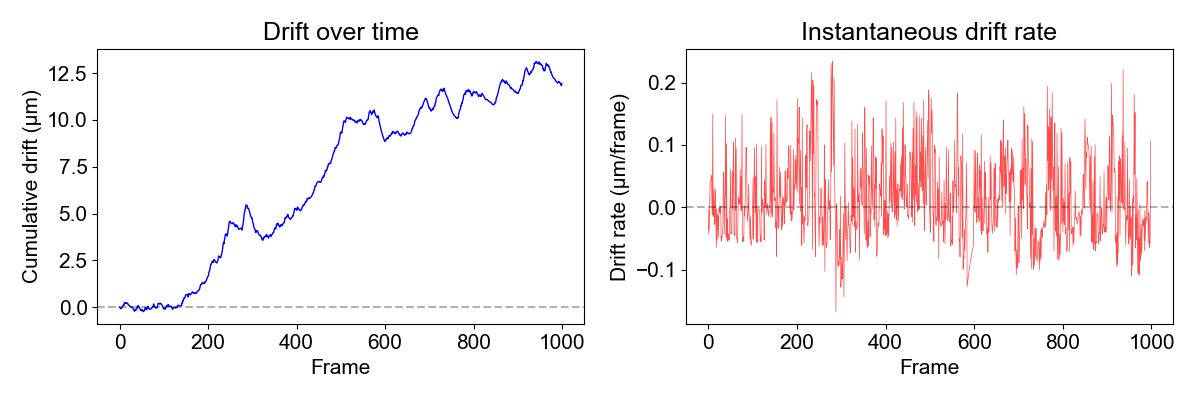

Mean drift rate: 0.0516 µm/frame
Max drift rate: 0.2341 µm/frame


In [96]:
# Additional drift analysis: detect periods of significant drift
drift_rate = np.diff(drift_um)  # µm per frame

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(drift_um, 'b-', linewidth=1)
plt.xlabel('Frame')
plt.ylabel('Cumulative drift (µm)')
plt.title('Drift over time')
plt.axhline(0, color='k', linestyle='--', alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(drift_rate, 'r-', linewidth=0.5, alpha=0.7)
plt.xlabel('Frame')
plt.ylabel('Drift rate (µm/frame)')
plt.title('Instantaneous drift rate')
plt.axhline(0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean drift rate: {np.mean(np.abs(drift_rate)):.4f} µm/frame")
print(f"Max drift rate: {np.max(np.abs(drift_rate)):.4f} µm/frame")

## 5. SEGMENT

- outputs `label.tif`, contains segmented MIP for each volume

### on home pc
`conda activate segment-torch`

Uses a separate conda environment from the rest of the pipeline. create it using:
`conda env create -f segment_torch.yml`

### on lab pc
`conda activate torchcu129`

Uses a separate conda environment from the rest of the pipeline. create it following steps in:
`segment_torch_cu129_environment.yml`

### setup each time model weights change
Need to set path to model weights as `CHECKPOINT` in `eval_torch.py`

In [ ]:
import segment.segment_torch
_ = importlib.reload(sys.modules['segment.segment_torch'])

MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'mip_channel_aligned.tif')

# command-line arguments
sys.argv = ["", MIP_PTH]

segment.segment_torch.main()

## 6. SPLINE

`conda activate g5ht-pipeline`

- outputs `spline.json`, `spline.tif`, and `dilated.tif`

In [ ]:
import spline
_ = importlib.reload(sys.modules['spline'])

LABEL_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'label.tif')

# command-line arguments
sys.argv = ["", LABEL_PTH]

spline.main()

## 7. ORIENT

`conda activate g5ht-pipeline`

- outputs `oriented.json`, `oriented.png`, `oriented_stack.tif`

NOTE: `orient_v2.py` automated the process of finding orientation completely, whereas `orient.py` requires you to input the (x,y) nose location on the first frame

In [ ]:
import orient_v2
_ = importlib.reload(sys.modules['orient_v2'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')

# command-line arguments
sys.argv = ["", SPLINE_PTH]

orient_v2.main()

In [ ]:
import orient
_ = importlib.reload(sys.modules['orient'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')
nose_y = 210
nose_x = 9

# command-line arguments
sys.argv = ["", SPLINE_PTH, str(nose_y), str(nose_x)]

orient.main()

## 8. WARP

`conda activate g5ht-pipeline`

- ouputs: `warped/*.tif` and `masks/*.tif`

TODO: parallelize

In [ ]:
import warp
_ = importlib.reload(sys.modules['warp'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 825
end_index = num_frames

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i]

    warp.main()

## 9. REGISTER

`conda activate g5ht-pipeline`

__ALTERNATIVELY__: register using the wholistic registration algorithm, currently in MATLAB

TODO: parallelize / make faster

In [ ]:
os.path.splitext(INPUT_ND2_PTH)[0]

In [ ]:
import reg
_ = importlib.reload(sys.modules['reg'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 0
end_index = num_frames
zoom = "1" # albert was using 3

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i, zoom]
    reg.main()

### REGISTER WITH GFP+1 TO RFP

TRIM LAST RFP ZSLICE, TRIM FIRST GFP ZSLICE

seems to be that as of 20251204, all recordings were taken such that the i zslice in red channel corresponds to i+1 zslice in green channel

In [ ]:
import sys
import os
from tqdm import tqdm
import importlib

from reg_gfp_indexing import main as reg_worm

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

for i in tqdm(range(1200)):
    # command-line arguments
    sys.argv = ["", PTH, i, "1"]
    reg_worm()

### MAKE MOVIES OF REGISTERED DATA (see `reg_microfilm.ipynb`)

## 10. LABEL ROIs

`conda activate g5ht-pipeline`

- after this step, use `lbl` conda env to label ROI of fixed frame
  - run `labelme` in terminal


maybe also see here for video annotation: https://github.com/wkentaro/labelme/tree/main/examples/video_annotation

### EXPORT FIXED VOLUME AS PNGs for labeling with `labelme`

In [ ]:
# code that exports each z-slice of fixed.tif as a separate png
import tifffile
import os
import glob
import scipy.ndimage as ndi

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

# in PTH directory, find a fixed_XXXX*.tif file, where XXXX are digits
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)

# fixed_pth = os.path.join(PTH, 'fixed.tif')
# fixed_stack = ndi.zoom(tifffile.imread(fixed_pth), zoom=(3,1,1,1))
fixed_stack = tifffile.imread(fixed_pth)

out_dir = os.path.join(PTH, 'fixed_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[0]):
    slice_pth = os.path.join(out_dir, f'fixed_z{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[i,1,:,:]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img) 

out_dir = os.path.join(PTH, 'fixed_xz_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[2]):
    slice_pth = os.path.join(out_dir, f'fixed_xz{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[:,1,i,:]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    tifffile.imwrite(slice_pth, slice_img) 

out_dir = os.path.join(PTH, 'fixed_yz_png')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(fixed_stack.shape[3]):
    slice_pth = os.path.join(out_dir, f'fixed_yz{i:02d}.png')
    # make sure to save channel 1, and that it is visible, correct data type, clipped to 0-255
    slice_img = fixed_stack[:,1,:,i]
    slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min()) * 255
    slice_img = slice_img.astype('uint8')
    # save as high quality tiff
    tifffile.imwrite(slice_pth, slice_img) 

### PARSE OUTPUT OF `labelme`

- outputs `roi.tif`

In [ ]:
import numpy as np
import json
from skimage.draw import polygon

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

out_dir = os.path.join(PTH, 'fixed_png')
fixed_fn = glob.glob(os.path.join(PTH, 'fixed_[0-9][0-9][0-9][0-9]*.tif'))[0]
fixed_pth = os.path.join(PTH, fixed_fn)
fixed_stack = tifffile.imread(fixed_pth)
Z,C,H,W = fixed_stack.shape

roi = np.zeros((Z, H, W), dtype=fixed_stack.dtype) # ZHW

roi_labels = ['PC','MC','IM','TB','NR','VNC','DNC']
# procorpus, metacorpus, isthmus, terminal bulb, nerve ring, ventral nerve cord, dorsal nerve cord

for i in range(Z):
    slice_roi_json = os.path.join(out_dir, f'fixed_z{i:02d}.json')
    # if slice_roi_json doesn't exist, continue
    if not os.path.exists(slice_roi_json):
        continue
    with open(slice_roi_json, 'r') as f:
        roi_dict = json.load(f)
        # loop through each shape in roi_dict['shapes']
        for shape in roi_dict['shapes']:
            label = shape['label']
            if label in roi_labels:
                points = shape['points']
                # get integer coordinates
                points = [(int(round(p[1])), int(round(p[0]))) for p in points]
                # create a mask for the polygon
                
                rr, cc = polygon([p[0] for p in points], [p[1] for p in points], shape=(H,W))
                # should set to correct z slice
                roi[i, rr, cc] = roi_labels.index(label) + 1 # start from 1

# save roi stack as tif image, imagej=true and save the roi labels as metadata
roi_pth = os.path.join(PTH, 'roi.tif')
tifffile.imwrite(roi_pth, roi.astype(np.uint8), imagej=True, metadata={'Labels': roi_labels})

## 11. QUANTIFY

`conda activate g5ht-pipeline`

Have to first label dorsal and ventral nerve rings and pharynx. See ...

In [ ]:
import sys
import os
import quantify
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import importlib

import matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.rcParams['svg.fonttype'] = 'none'

_ = importlib.reload(sys.modules['quantify'])

PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
REG_DIR = r'registered_wholistic_smooth-0.200_patch-7'
PLOT_ONLY = True

%matplotlib qt

sys.argv = ["", PTH, REG_DIR, PLOT_ONLY]
quantify.main()

## 12 QUANTIFY VOXELS

In [ ]:
import sys
import os
import quantify_voxels
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.morphology import erosion, disk
import importlib
import glob

import matplotlib
%matplotlib widget
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

_ = importlib.reload(sys.modules['quantify_voxels'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
reg_dir = 'registered'
bin_factor = 2
fps = 1/0.533

sys.argv = ["", PTH, reg_dir, bin_factor]
quantify_voxels.main()

In [ ]:
# load normalized_voxels.npy, also been binned
g5 = np.load(os.path.join(PTH, 'normalized_voxels.npy'))
rfp_mean = np.load(os.path.join(PTH, 'rfp_mean.npy'))
gfp_mean = np.load(os.path.join(PTH, 'gfp_mean.npy'))
baseline = np.load(os.path.join(PTH, 'baseline.npy'))

# load mask, bin it
# find the fixed_mask_*.tif file in PTH directory
try:
    fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask_*.tif'))[0]
except:
    fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask*.tif'))[0]

mask = tifffile.imread(fixed_mask_fn)

h, w = mask.shape
h_binned = h // bin_factor
w_binned = w // bin_factor
# binning of mask
mask_binned = mask.reshape(h_binned, bin_factor, w_binned, bin_factor).max(axis=(1,3))

In [ ]:
g5_masked = g5 * mask_binned[np.newaxis, :, :]

In [ ]:
print(g5.shape)
print(rfp_mean.shape)
print(gfp_mean.shape)
print(baseline.shape)
print(mask_binned.shape)

In [ ]:
g5_masked.shape

# g5_masked is shape (T, Z, H, W) array with zeros outside the worm region
# find all voxels where g5_masked is zero for each time point
zero_mask = g5_masked == 0
# calculate the probability of a voxel being zero across time, but don't include time points where the voxel is masked out (i.e., outside the worm)
zero_prob = np.mean(zero_mask, axis=0)
# set zero probability to NaN for voxels outside the worm (mask binned needs a z dimension added)
zero_prob[mask_binned[np.newaxis].repeat(zero_prob.shape[0], axis=0) == 0] = np.nan

plt.close('all')
%matplotlib qt
# plot zero_prob as an image, with colorbar, for each z slice in subplots
fig, axes = plt.subplots(4, 10, figsize=(20, 8), constrained_layout=True)
for z in range(zero_prob.shape[0]):
    ax = axes[z // 10, z % 10]
    im = ax.imshow(zero_prob[z, :, :], cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Z={z}')
    ax.axis('off')
    # replace last subplot with colorbar
    if z == zero_prob.shape[0] - 1:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
# delete last subplots if z slices are less than 40
for z in range(zero_prob.shape[0], 40):
    ax = axes[z // 10, z % 10]
    ax.axis('off')
plt.show()

plt.figure()
plt.hist(zero_prob.flatten(), bins=50, color='blue', alpha=0.7)
plt.xlabel('Probability of Voxel Being Zero')
plt.ylabel('Frequency')
plt.title('Histogram of Zero Probability Across Voxels')
plt.show()

In [ ]:
probability_threshold = 0.3 # if a voxel is zero more than this fraction of the time, consider it outside the worm or a bad voxel
# create a mask of good voxels
good_voxel_mask = zero_prob < probability_threshold
normalized_data = g5_masked * good_voxel_mask[np.newaxis].repeat(g5_masked.shape[0], axis=0)

In [ ]:
normalized_data.shape

In [ ]:
norm_data_mean = np.mean(normalized_data, axis=0)

# clip norm_data mean between 0th and 99th percentiles
p0 = np.percentile(norm_data_mean, 0)
p99 = np.percentile(norm_data_mean, 99)
norm_data_mean = np.clip(norm_data_mean, p0, p99)

z2plot = [0,5,15,25,35]
# z2plot = [0,5]

%matplotlib inline
plt.close('all')
fig, axes = plt.subplots(len(z2plot), 3, figsize=(15, 9), constrained_layout=True)
for i in z2plot: # for each z slice
    plt.subplot(len(z2plot), 3, z2plot.index(i)*3+1)
    plt.pcolor(gfp_mean[i,:,:])
    plt.title(f'GFP Mean Z={i}')
    # plt.colorbar()

    plt.subplot(len(z2plot), 3, z2plot.index(i)*3+2)
    plt.pcolor(rfp_mean[i,:,:])
    plt.title(f'RFP Mean Z={i}')
    # plt.colorbar()

    plt.subplot(len(z2plot), 3, z2plot.index(i)*3+3)
    plt.pcolor(norm_data_mean[i,:,:])
    # add colorbar outside to the right
    plt.colorbar()
    # plt.clim(0, 12)
    # make all axes not be squished
plt.show()


In [ ]:
# cluster normalized_data using k means
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
T, Z, H, W = normalized_data.shape
normalized_data_reshaped = normalized_data.reshape(T, Z*H*W).T  # shape (Z*H*W, T)
kmeans.fit(normalized_data_reshaped)


In [ ]:
# plot cluster mean activity over time
cluster_means = np.zeros((n_clusters, T))
for c in range(n_clusters):
    cluster_means[c, :] = normalized_data_reshaped[kmeans.labels_ == c, :].mean(axis=0)

In [ ]:
plt.figure(figsize=(10,6))
t = np.arange(T) * (1/fps)
ic = 0
for c in range(6,9):#range(n_clusters):
    plt.plot(t, cluster_means[c, :], label=f'Cluster {ic+1}')
    ic += 1
plt.legend(frameon=False)
plt.xlabel('Time (sec)')
plt.ylabel('$\ R / R_{baseline}$')
plt.show()

In [ ]:
# plot cluster 1 and 2 spatial maps at each z slice
plt.close('all')
ic = 0
for c in range(6,9):#range(n_clusters):
    fig, axes = plt.subplots(4, 10, figsize=(20, 8), constrained_layout=True)
    for z in range(Z):
        ax = axes[z // 10, z % 10]
        cluster_map = kmeans.labels_.reshape(Z, H, W)[z, :, :] == c
        im = ax.imshow(cluster_map, cmap='gray')
        ax.set_title(f'Cluster {ic+1} Z={z}')
        ax.axis('off')
    plt.suptitle(f'Spatial Map of Cluster {c+1} Across Z Slices')
    ic += 1
    # deleate last subplots if z slices are less than 40
    for z in range(Z, 40):
        ax = axes[z // 10, z % 10]
        ax.axis('off')
    plt.show()

In [ ]:
# PCA
from sklearn.decomposition import PCA
# flatten normalized_data to (T, Z*H*W)
T, Z, H, W = normalized_data.shape
data_reshaped = normalized_data.reshape(T, Z*H*W)
pca = PCA(n_components=5)
pca.fit(data_reshaped)

In [ ]:

# get scores, plot
scores = pca.transform(data_reshaped)
# plot the first 5 principal component scores
for i in range(5):
    plt.figure()
    plt.plot(scores[:,i])
    plt.show()

# plot the first 5 principal component weights as images across z slices
components = pca.components_



In [ ]:

# plot gfp_mean, rfp_mean, dat in a (5,3) grid of subplots (5 z slices, 3 columns)


# divide gfp_mean by rfp_mean, but only if rfp_mean is not zero

dat = gfp_mean / rfp_mean
# dat = np.divide(gfp_mean, rfp_mean, out=np.zeros_like(gfp_mean), where=rfp_mean!=0)
# divide each voxel in dat by its baseline, but only if baseline is not zero
dat = np.divide(dat, baseline, out=np.zeros_like(dat), where=baseline!=0)
dat = dat * mask_binned[np.newaxis, :, :]

# remove outliers by clipping to 1st and 99th percentile
p1 = np.percentile(dat, 0)
p99 = np.percentile(dat, 99.9)
dat = np.clip(dat, p1, p99)


# plt.figure()
# plt.hist(baseline.ravel(), bins=1000, range=(0,100))
# plt.show()

# z2plot = [0,5,15,25,35]
z2plot = [0,5]

%matplotlib inline
plt.close('all')
fig, axes = plt.subplots(len(z2plot), 3, figsize=(15, 5), constrained_layout=True)
for i in z2plot: # for each z slice
    plt.subplot(len(z2plot), 3, z2plot.index(i)*3+1)
    plt.pcolor(gfp_mean[i,:,:])
    plt.title(f'GFP Mean Z={i}')
    # plt.colorbar()

    plt.subplot(len(z2plot), 3, z2plot.index(i)*3+2)
    plt.pcolor(rfp_mean[i,:,:])
    plt.title(f'RFP Mean Z={i}')
    # plt.colorbar()

    plt.subplot(len(z2plot), 3, z2plot.index(i)*3+3)
    plt.pcolor(dat[i,:,:])
    # add colorbar outside to the right
    plt.colorbar()
    plt.clim(0, 12)
    # make all axes not be squished
plt.show()


In [ ]:
# load mask, bin
# find the fixed_mask_*.tif file in PTH directory
try:
    fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask_*.tif'))[0]
except:
    fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask*.tif'))[0]

mask = tifffile.imread(fixed_mask_fn)

h, w = mask.shape
h_binned = h // bin_factor
w_binned = w // bin_factor
# binning of mask
mask_binned = mask.reshape(h_binned, bin_factor, w_binned, bin_factor).max(axis=(1,3))
# shrink the mask slightly using erosion skimage
mask_binned = erosion(mask_binned, disk(5))

# zero out values outside the mask
g5_masked = g5 * mask_binned[np.newaxis,np.newaxis,:,:]



In [ ]:
g5_masked.shape

In [ ]:
g5_masked_trimmed  = g5_masked[:, 5:27, :,40:230]
g5_masked_trimmed.shape

In [ ]:
plt.close('all')

# get the intensity over time of the voxels in the middle of the (x,y) plane, definding a box, and all z slices
middle_x = int(g5_masked_trimmed.shape[3] // 1.5)
middle_y = int(g5_masked_trimmed.shape[2] // 1.95)
box_size = 10  # Define the size of the box around the middle point
middle_voxels = g5_masked_trimmed[:, 5:27, middle_y-box_size:middle_y+box_size, middle_x-box_size:middle_x+box_size].mean(axis=(2,3))
# divide each z slice by the mean activity in the first 60 time points to get F/F0
middle_voxels = middle_voxels / (middle_voxels[:60,:].mean(axis=0) + 1e-6)

t = np.arange(middle_voxels.shape[0]) / fps

plt.close('all')

plt.figure(figsize=(10, 6))
plt.plot(middle_voxels)
plt.xlabel('Time (sec)')
plt.ylabel('$F/F_{\\mathrm{baseline}}$')
# plt.ylim(0, 5)
plt.show()
# plot same thing as heatmap and sort by mean signal across time for each z slice
sorted_indices = np.argsort(middle_voxels.mean(axis=0))
middle_voxels_sorted = middle_voxels[:, sorted_indices]

plt.figure(figsize=(10, 6))
plt.pcolor(t, np.arange(middle_voxels.shape[1]), middle_voxels_sorted.T, cmap='plasma',vmin=0,vmax=5)
plt.colorbar(label='$F/F_{\\mathrm{baseline}}$')
plt.xlabel('Time (sec)')
plt.ylabel('Z slice (sorted by mean intensity)')
plt.show()

# plot g5_masked and the box defined by box_size and middle_x, middle_y to confirm that the box is in the middle of the (x,y) plane and covers the expected area
for i in range(g5_masked_trimmed.shape[1]):
    plt.figure(figsize=(10, 4))
    plt.pcolor(g5_masked_trimmed[158,i,:,:],vmin=0, vmax=10)
    plt.plot([middle_x-box_size, middle_x+box_size, middle_x+box_size, middle_x-box_size, middle_x-box_size],
             [middle_y-box_size, middle_y-box_size, middle_y+box_size, middle_y+box_size, middle_y-box_size], color='red')
    plt.show()

# GRID ANALYSIS

In [ ]:
import grid_analysis
import sys
import importlib
_ = importlib.reload(sys.modules['grid_analysis'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

xspace = 10
yspace = 10
fps = 1/0.533
bin_factor = 1
z_start = 5
z_end = 25
baseline_start_sec = 5 # start baseline calculation here (relative to the start of the recording, not relative to start_time_sec)
baseline_end_sec = 35 # end baseline calculation here (relative to the start of the recording, not relative to start_time_sec)
start_time_sec = 0
time_food_sec = 435
sys.argv = ["", PTH, xspace, yspace, fps, bin_factor, z_start, z_end, baseline_start_sec, baseline_end_sec, start_time_sec]#time_food_sec] 
grid_analysis.main()

In [ ]:
import grid_analysis
_ = importlib.reload(sys.modules['grid_analysis'])
# load the grid_timeseries_flat_smoothed.npz file and plot the heatmap using the plot_heatmap function
data = np.load(os.path.join(PTH, 'grid_timeseries_flat_smoothed.npz'))
flat_timeseries_smoothed = data['timeseries']
z_labels = data['z_labels']
grid_analysis.plot_heatmap(flat_timeseries_smoothed, z_labels, fps=1/0.533, output_path=os.path.join(PTH, 'grid_heatmap.png'), data_start_time=start_time_sec)
# grid_analysis.plot_heatmap(flat_timeseries_smoothed, z_labels, fps=1/0.533, output_path=os.path.join(PTH, 'grid_heatmap.png'), data_start_time=start_time_sec)

In [ ]:
flat_timeseries_smoothed.shape

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(flat_timeseries_smoothed.shape[0])/fps,flat_timeseries_smoothed[:,20:27])
# plt.ylim(0.03,0.3)
plt.show()

In [ ]:
np.unique(z_labels)

In [ ]:
flat_timeseries_smoothed.shape

In [ ]:
_ = importlib.reload(sys.modules['grid_analysis'])
# sort the grid squares by their mean signal across time, and plot the heatmap again with the grid squares in sorted order
mean_signal_grid = flat_timeseries_smoothed.mean(axis=0)
sorted_indices = np.argsort(mean_signal_grid)
flat_timeseries_smoothed_sorted = flat_timeseries_smoothed[:, sorted_indices]

plt.close('all')

# smooth some more
from grid_analysis import causal_smooth
toplot = causal_smooth(flat_timeseries_smoothed_sorted, sigma=1.0)
grid_analysis.plot_heatmap(toplot, z_labels, fps=1/0.533, output_path=os.path.join(PTH, 'grid_heatmap_sorted.png'), data_start_time=start_time_sec)
# plt.xlim(-50,125)
# plt.ylim(50,770)

# plot the mean signal across all grid squares for each z-slice over time, and mark the time of food addition
mean_signal_grid = flat_timeseries_smoothed.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(flat_timeseries_smoothed.shape[0])/fps - start_time_sec, mean_signal_grid)
plt.axvline(0, color='red', linestyle='--', label='Food addition')
plt.xlabel('Time (sec)')
plt.ylabel('Mean $F/F_{\\mathrm{baseline}}$ across grid squares')
plt.legend()
# plt.xlim(-50,125)
# plt.ylim(0.03,0.3)
plt.show()

In [ ]:
flat_timeseries_smoothed.shape

In [ ]:
# pca on flat_timeseries_smoothed, which of size (time,features)
from sklearn.decomposition import PCA
import utils
pca = PCA(n_components=5)
pca.fit(flat_timeseries_smoothed)
# get scores
pc_scores = pca.transform(flat_timeseries_smoothed)
explained_variance = pca.explained_variance_ratio_
explained_variance


line_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
ylim = (-12,14)
for i in range(5):
    fig, ax = utils.pretty_plot()
    ax.plot(np.arange(pc_scores.shape[0])/fps, pc_scores[:,i], label=f'PC{i+1}', lw=3, color=line_colors[i])
    ax.set_ylim(ylim)
    ax.set_xlabel('Time (sec)')
    plt.ylabel(f'PC{i+1} projection')
    plt.show()

# scree plot
fig, ax = utils.pretty_plot()
ax.bar(np.arange(len(explained_variance))+1, explained_variance*100)
ax.set_xlabel('PC')
ax.set_ylabel('Variance explained (%)')
plt.show()

In [ ]:
# cluster flat_timeseries_smoothed, then plot heatmap with clusters indicated
from sklearn.cluster import KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(flat_timeseries_smoothed.T)
cluster_labels = kmeans.labels_


In [ ]:
plt.figure()
plt.plot(sorted_timeseries)
plt.show()

In [ ]:
# sort flat_timeseries_smoothed by cluster labels
sorted_indices = np.argsort(cluster_labels)
sorted_timeseries = flat_timeseries_smoothed[:, sorted_indices]

plt, ax = utils.pretty_plot(figsize=(10,6))
im = ax.pcolormesh(sorted_timeseries.T, cmap='plasma')
plt.show()

# plot mean of each cluster over time on the same axis
i = 0
for c in range(n_clusters-1):
    cluster_mean = flat_timeseries_smoothed[:, cluster_labels == c].mean(axis=1)
    # normalize between 0 and 1
    cluster_mean = (cluster_mean - cluster_mean.min()) / (cluster_mean.max() - cluster_mean.min())
    # smooth cluste means
    # cluster_mean = pca_analysis.causal_smooth(cluster_mean[:,np.newaxis], sigma=3.0)
    if i==0:
        fig, ax = utils.pretty_plot()
    ax.plot(np.arange(cluster_mean.shape[0])/fps, cluster_mean, lw=1)
    ax.set_xlabel('Time (sec)')
    # plt.ylabel(f'Cluster {c+1} mean $F/F_{{\\mathrm{{baseline}}}}$')
    i += 1
plt.show()

# cross correlation between cluster 1 and 2 means signals
from scipy.signal import correlate
cluster1_mean = flat_timeseries_smoothed[:, cluster_labels == 0].mean(axis=1)
cluster2_mean = flat_timeseries_smoothed[:, cluster_labels == 1].mean(axis=1)
# normalize means bwetween 0 and 1
cluster1_mean = (cluster1_mean - cluster1_mean.min()) / (cluster1_mean.max() - cluster1_mean.min())
cluster2_mean = (cluster2_mean - cluster2_mean.min()) / (cluster2_mean.max() - cluster2_mean.min())
# compute cross-correlation
corr = correlate(cluster1_mean - cluster1_mean.mean(), cluster2_mean - cluster2_mean.mean(), mode='full')
lags = np.arange(-len(cluster1_mean)+1, len(cluster1_mean))
# plot xcorr
fig, ax = utils.pretty_plot()
ax.plot(lags/fps, corr)
ax.set_xlabel('Lag (sec)')
ax.set_ylabel('Cross-correlation')
plt.show()

# PCA analysis

In [ ]:
import pca_analysis
import sys
_ = importlib.reload(sys.modules['pca_analysis'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# Arguments: input_dir, fps, bin_factor, z_start, z_end, lowpass_freq, n_components,
#            n_pcs_plot, baseline_start, baseline_end, start_time, time_offset
sys.argv = ["", PTH, 1/0.533, 1, 7, 18, 0, 50, 6, 5, 35, 0]
pca_analysis.main()

# DMD analysis

In [ ]:
import dmd_analysis
import sys
_ = importlib.reload(sys.modules['dmd_analysis'])

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# Arguments: input_dir, fps, bin_factor, z_start, z_end, lowpass_freq, dmd_rank, 
#            n_modes_plot, baseline_start, baseline_end, start_time, time_offset
sys.argv = ["", PTH, 1/0.533, 1, 7, 18, 0, 5, 6, 5, 35, 0]

dmd_analysis.main()